In [23]:
#DATA AUGMENTATION

# Importing necessary functions
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os

def augment_images(image_path, filename):
		# Loading a sample image
		img = load_img(image_path)
		# Converting the input sample image to an array
		x = img_to_array(img)
		# Reshaping the input image
		x = x.reshape((1, ) + x.shape)

		# Generating and saving 5 augmented samples
		# using the above defined parameters.
		i = 0
		for batch in datagen.flow(x, batch_size = 16,
								save_to_dir ='C:/Users/Camille/Downloads/NEW PATH 2', #Camille
								# save_to_dir ='D:/Program Files/NEW CROPPED LABELED RESIZED PRES PICS', #Ash
								save_prefix =filename+'_'+str(i), save_format ='jpg'):
			i += 1
			if i > 5:
				break

# Initialising the ImageDataGenerator class.
# We will pass in the augmentation parameters in the constructor.
datagen = ImageDataGenerator(
		rotation_range = 5,
		shear_range = 1,
		zoom_range = 0.2,
		rescale=1)

input_path = 'C:/Users/Camille/Downloads/CROPPED LABELED RESIZED PRES PICS 2' #Camille
# input_path = 'D:\Program Files\CROPPED LABELED RESIZED PRES PICS' #Ash
for filename in os.listdir(input_path):
	if filename.endswith(".jpg"):
		image_path = os.path.join(input_path, filename)
		augment_images(image_path, filename[:-4])

In [26]:
# # Creating Train / Val / Test folders (One time use)
import os
import numpy as np
import shutil
import random
root_dir = 'C:/Users/Camille/Downloads/splitted data 2/' #Camille
# root_dir = 'D:/Program Files/SPLIT NEW CROPPED LABELED RESIZED PRES PICS/' #Ash


val_ratio = 0
test_ratio = 0.3

os.makedirs(root_dir +'train/')
os.makedirs(root_dir +'test/')

# Creating partitions of the data after shuffeling
src = 'C:/Users/Camille/Downloads/NEW PATH 2' # Folder to copy images from --Camille
# src = 'D:/Program Files/NEW CROPPED LABELED RESIZED PRES PICS' #Ash


allFileNames = os.listdir(src)
np.random.shuffle(allFileNames)
train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), 
                                                           int(len(allFileNames)* (1 - test_ratio))])


train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

print('Total images: ', len(allFileNames))
print('Training: ', len(train_FileNames))
#print('Validation: ', len(val_FileNames))
print('Testing: ', len(test_FileNames))

# Copy-pasting images
for name in train_FileNames:
    shutil.copy(name, root_dir +'train/' )

#for name in val_FileNames:
 #   shutil.copy(name, root_dir +'val/' + cls)

for name in test_FileNames:
    shutil.copy(name, root_dir +'test/' )

Total images:  288
Training:  201
Testing:  87


In [1]:
#BINARIZATION
import cv2
import numpy as np
from skimage.filters import threshold_otsu

def binary(image):
    (thresh, im_bw) = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    thresh = 127
    im_bw = cv2.threshold(image, thresh, 255, cv2.THRESH_BINARY)[1]
    return im_bw

In [2]:
#NOISE REMOVAL
import bm3d
def noise(bw):
    # den = bm3d.bm3d(bw, sigma_psd=30/255, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
    den = cv2.fastNlMeansDenoising(bw, None, 10, 7, 15)
    return den

In [3]:
#CED
from scipy import signal

def ced(image):
    m1 = np.array([[5, 5, 5],[-3,0,-3],[-3,-3,-3]])
    m8 = np.array([[-3, 5,5],[-3,0,5],[-3,-3,-3]])
    m7 = np.array([[-3,-3,5],[-3,0,5],[-3,-3,5]])
    m6 = np.array([[-3,-3,-3],[-3,0,5],[-3,5,5]])
    m5 = np.array([[-3, -3, -3],[-3,0,-3],[5,5,5]])
    m4 = np.array([[-3, -3, -3],[5,0,-3],[5,5,-3]])
    m3 = np.array([[5, -3, -3],[5,0,-3],[5,-3,-3]])
    m2 = np.array([[5, 5, -3],[5,0,-3],[-3,-3,-3]])
    list_m = [m1,m2,m3,m4,m5,m6,m7,m8]

    list_e = []
    count = 1
    
    for m in list_m:
        imgk = signal.convolve2d(image, m,boundary='symm')
        list_e.append(np.abs(imgk))
        out = imgk.astype(np.uint8)
        count += 1
    #Seeking maximum
    count
    e = list_e[0]
    for i in range(len(list_e)):
        e = e*(e>=list_e[i]) + list_e[i]*(e<list_e[i])
        
    e[e>255] = 255
    e=e.astype(np.uint8)
    return e

In [4]:
from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert

def skeleton(image):
    return cv2.ximgproc.thinning(image)


In [6]:
#PREPROCESSING IMAGES
import time
import matplotlib.image as imgsave
# import pandas as pd
filename = 'C:/Users/Camille/Downloads/splitted data 2/train/'
filename2 = 'C:/Users/Camille/Downloads/splitted data 2/test/'
# filename = 'D:/Program Files/SPLIT NEW CROPPED LABELED RESIZED PRES PICS/train/' #Ash
# filename2 = 'D:/Program Files/SPLIT NEW CROPPED LABELED RESIZED PRES PICS/test/' #Ash


def preprocess(train_dir):
    start_time = time.time()
    list_images = []
    for filename in os.listdir(train_dir):
        image = cv2.imread(os.path.join(train_dir, filename),0)
        img2 = binary(image)
        img3 = noise(img2)
        imgg = cv2.blur(img3,(3,3))
        img4 = ced(imgg)
        img5 = skeleton(img4)
        # img5 = tf.convert_to_tensor(img5)
        list_images.append(img5)
    print("--- %s seconds --- skeleton image" % (time.time() - start_time))
    list_images = np.array(list_images, np.int64)
    return list_images

list_train_images = preprocess(filename)
list_test_images = preprocess(filename2)
print(list_train_images)
print(list_test_images)

# filepath='C:/Users/Camille/Downloads/pagod na ko/'

# image = cv2.imread('C:/Users/Camille/Downloads/splitted data/train/Hydroxyzine_0_8889.jpg',0)

# img = binary(image)
# img2 = noise(img)

# img3 = cv2.blur(img2, ksize=(3,3))

# img4 = ced(img3)
# img5 = skeleton(img4)

# cv2.imwrite(os.path.join(filepath,"1grey.jpg"), image)  
# cv2.imwrite(os.path.join(filepath,"2binary.jpg"), img)  
# cv2.imwrite(os.path.join(filepath,"3noise.jpg"), img2)  
# cv2.imwrite(os.path.join(filepath,"4blur.jpg"), img3)  
# cv2.imwrite(os.path.join(filepath,"5ced.jpg"), img4) 
# cv2.imwrite(os.path.join(filepath,"6skeleton.jpg"), img5) 


--- 59.336859941482544 seconds --- skeleton image
--- 24.08628249168396 seconds --- skeleton image
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]


In [ ]:
# import tensorflow as tf

# from tensorflow.keras import datasets, layers, models
# import matplotlib.pyplot as plt

# (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# # print(train_images)
# image = cv2.imread(os.path.join(filepath,"6skeleton.jpg"))
# image2 = cv2.imread(os.path.join(filepath,"6skeleton.jpg"))
# list1 = []
# list1.append(image)
# list1.append(image2)
# list2 = np.array(list1, np.int32)
# print(list2)


In [7]:
#CNN ASH
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


import cv2
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import tensorflow.keras.backend as K

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional, LSTM
# from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm import tqdm
from collections import Counter
from PIL import Image
from itertools import groupby


In [273]:
# image_paths = []
image_texts = []
from pathlib import Path
# data_folder = "D:/Program Files/SPLIT NEW CROPPED LABELED RESIZED PRES PICS/train" #Ash
data_folder = 'C:/Users/Camille/Downloads/splitted data 2/train'
data_dir = Path("C:/Users/Camille/Downloads/splitted data 2/train")
image_paths = sorted(list(map(str, list(data_dir.glob("*.jpg")))))
print(len(image_paths))
for filename in os.listdir(data_dir):
    # image_paths.append(data_folder + "/" + filename)
    # image_texts.append(filename.split("/")[0])
    if filename.find("Azathioprine") != -1:
        image_texts.append("Azathioprine: 3-5 mg/kg Per os OD")
        # image_texts.append("Azathioprine 3 5 mg kg Per os OD")
    elif filename.find("Ceftriaxone") != -1:
        image_texts.append("Ceftriaxone: 2 g IV q24h")
        # image_texts.append("Ceftriaxone 2 g IV q24h")
    elif filename.find("Chlorpromazine") != -1:
        image_texts.append("Chlorpromazine: 10-25 mg Per os three times a day")
        # image_texts.append("Chlorpromazine 10 25 mg Per os three times a day")
    elif filename.find("Dobutamine") != -1:
        image_texts.append("Dobutamine: 2.5-15 mcg/kg/min")
        # image_texts.append("Dobutamine 2 5 15 mcg kg min")
    elif filename.find("Hydroxyzine") != -1:
        image_texts.append("Hydroxyzine: 50-100 mg by IJ qds")
        # image_texts.append("Hydroxyzine 50 100 mg by IJ qds")
    elif filename.find("Lorazepam") != -1:
        image_texts.append("Lorazepam: 1 mg Per os 2 times a day")
        # image_texts.append("Lorazepam 1 mg Per os 2 times a day")
    elif filename.find("Metronidazole") != -1:
        image_texts.append("Metronidazole: 7.5 mg/kg Per os q6hr")
        # image_texts.append("Metronidazole 7 5 mg kg Per os q6hr")
    elif filename.find("Prednisolone") != -1:
        image_texts.append("Prednisolone: 5-60 mg per day qds")
        # image_texts.append("Prednisolone 5 60 mg per day qds")
    elif filename.find("Quinine") != -1:
        image_texts.append("Quinine: 648 mg Per os every 8 hours for 7 days")
        # image_texts.append("Quinine 648 mg Per os every 8 hours for 7 days")
    elif filename.find("Risperidone") != -1:
        image_texts.append("Risperidone: 2 mg orally i/d")
        # image_texts.append("Risperidone 2 mg orally i d")
    elif filename.find("Rituximab") != -1:
        image_texts.append("Rituximab: 375 mg/m2 IV once weekly")
        # image_texts.append("Rituximab 375 mg m2 IV once weekly")
    else:
        image_texts.append("Tramadol: 50-100 mg as needed every 4 to 6 hours")
        # image_texts.append("Tramadol 50100 mg as needed every 4 to 6 hours")
print(type(image_paths))

201
<class 'list'>


In [274]:
# char_list = set(['0','1','2','3','4','5','6','7','8','A','C','D','H','I','J','L','M','O','P','Q','R','T','V','a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',' '])
char_list = ['-', '.', '/','0','1','2','3','4','5','6','7','8',':','A','C','D','H','I','J','L','M','O','P','Q','R','T','V','a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',' ']
# char_list = set(['0','1','2','3','4','5','6','7','8','A','C','D','H','I','J','L','M','O','P','Q','R','T','V','a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',' '])

In [275]:
max_label_len = 49

In [276]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

# Splitting data into training and validation sets
train_image_paths, val_image_paths, train_image_texts, val_image_texts = split_data(np.array(image_paths), np.array(image_texts))
print(len(train_image_paths))
print(len(val_image_paths))

180
21


In [277]:
def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)

    return pad_sequences([dig_lst], maxlen=max_label_len, padding='post', value=len(char_list))[0]

In [278]:
# padded_image_texts = list(map(encode_to_labels, image_texts))

In [279]:
# train_image_paths = image_paths[ : int(len(image_paths) * 0.90)]

# train_image_texts = padded_image_texts[ : int(len(image_texts) * 0.90)]
# print(len(train_image_texts))
# val_image_paths = image_paths[int(len(image_paths) * 0.90) : ]
# val_image_texts = padded_image_texts[int(len(image_texts) * 0.90) : ]
# print(len(val_image_texts))

In [301]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(char_list), num_oov_indices=0, mask_token=None
)
def process_single_sample(img_path, label):

    # 1. Read image
    img = tf.io.read_file(img_path)

    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float64) #initially 32

    # 4. Resize to the desired size
    img = tf.image.resize(img, [64, 256])
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    #
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))

    
    return {"image": img, "label": label}

In [302]:
batch_size = 1
# print(type(train_image_paths))
# print(type(train_image_texts))
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_image_texts))
# print(train_dataset)
train_dataset = (
    train_dataset.map(
        process_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_image_texts))
validation_dataset = (
    validation_dataset.map(
        process_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [303]:
class CTCLayer(layers.Layer):

    def __init__(self, name=None):
        
        super().__init__(name=name)        
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [304]:
def ctc_decoder(predictions):
    '''
    input: given batch of predictions from text rec model
    output: return lists of raw extracted text

    '''
    text_list = []
    
    pred_indcies = np.argmax(predictions, axis=2)
    
    for i in range(pred_indcies.shape[0]):
        ans = ""
        
        ## merge repeats
        merged_list = [k for k,_ in groupby(pred_indcies[i])]
        
        ## remove blanks
        for p in merged_list:
            if p != len(char_list):
                ans += char_list[int(p)]
        
        text_list.append(ans)
        
    return text_list


In [292]:
# figures_list = []

# class PlotPredictions(tf.keras.callbacks.Callback):

#     def __init__(self, frequency=1):
#         self.frequency = frequency
#         super(PlotPredictions, self).__init__()

#         batch = validation_dataset.take(1)
#         self.batch_images = list(batch.as_numpy_iterator())[0]["image"]
#         self.batch_labels = list(batch.as_numpy_iterator())[0]["label"]

#     def plot_predictions(self, epoch):

#         prediction_model = keras.models.Model(
#             self.model.get_layer(name="image").input, 
#             self.model.get_layer(name="dense").output
#         )
        
#         preds = prediction_model.predict(self.batch_images)
#         pred_texts = ctc_decoder(preds)

#         orig_texts = []

#         for label in self.batch_labels:
#             orig_texts.append("".join([char_list[int(char_ind)] for char_ind in label if not(char_ind == len(char_list))]))

#         fig , ax = plt.subplots(4, 4, figsize=(15, 5))
#         fig.suptitle('Epoch: '+str(epoch), weight='bold', size=14)

#         for i in range(16):

#             img = (self.batch_images[i, :, :, 0] * 255).astype(np.uint8)
#             title = f"Prediction: {pred_texts[i]}"
#             ax[i // 4, i % 4].imshow(img, cmap="gray")
#             ax[i // 4, i % 4].set_title(title)
#             ax[i // 4, i % 4].axis("off")
        
#         plt.show()
#         #plt.savefig("predictions_epoch_"+ str(epoch)+'.png', bbox_inches = 'tight', pad_inches = 0)
        
#         figures_list.append(fig)

#     def on_epoch_end(self, epoch, logs=None):
#         if epoch % self.frequency == 0:
#             self.plot_predictions(epoch) 
#             figures_list = []

# class PlotPredictions(tf.keras.callbacks.Callback):

#     def __init__(self, frequency=1):
#         self.frequency = frequency
#         super(PlotPredictions, self).__init__()

#         batch = validation_dataset.take(1)
#         self.batch_images = list(batch.as_numpy_iterator())[0]["image"]
#         self.batch_labels = list(batch.as_numpy_iterator())[0]["label"]

#     def plot_predictions(self, epoch):

#         prediction_model = keras.models.Model(
#             self.model.get_layer(name="image").input, 
#             self.model.get_layer(name="dense").output
#         )
        
#         preds = prediction_model.predict(self.batch_images)
#         pred_texts = ctc_decoder(preds)

#         orig_texts = []

#         for label in self.batch_labels:
#             orig_texts.append("".join([char_list[int(char_ind)] for char_ind in label if not(char_ind == len(char_list))]))

#         fig , ax = plt.subplots(4, 4, figsize=(15, 5))
#         fig.suptitle('Epoch: '+str(epoch), weight='bold', size=14)

#         for i in range(16):

#             img = (self.batch_images[i, :, :, 0] * 255).astype(np.uint8)
#             title = f"Prediction: {pred_texts[i]}"
#             ax[i // 4, i % 4].imshow(img, cmap="gray")
#             ax[i // 4, i % 4].set_title(title)
#             ax[i // 4, i % 4].axis("off")
        
#         plt.show()
#         #plt.savefig("predictions_epoch_"+ str(epoch)+'.png', bbox_inches = 'tight', pad_inches = 0)
        
#         figures_list.append(fig)

#     def on_epoch_end(self, epoch, logs=None):
#         if epoch % self.frequency == 0:
#             self.plot_predictions(epoch)

In [293]:
# def train(epochs):
    
#     # input with shape of height=32 and width=128 
#     inputs = Input(shape=(32, 128, 1), name="image", dtype="float32")

#     labels = layers.Input(name="label", shape=(None,), dtype="float32")

#     conv_1 = Conv2D(64, (3,3), activation = "selu", padding='same')(inputs)
#     pool_1 = MaxPool2D(pool_size=(2, 2))(conv_1)
    
#     conv_2 = Conv2D(64, (3,3), activation = "selu", padding='same')(pool_1)
#     pool_2 = MaxPool2D(pool_size=(2, 2))(conv_2)

#     conv_3 = Conv2D(128, (3,3), activation = "selu", padding='same')(pool_2)
#     conv_4 = Conv2D(128, (3,3), activation = "selu", padding='same')(conv_3)

#     pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
    
#     conv_5 = Conv2D(256, (3,3), activation = "selu", padding='same')(pool_4)
    
#     # Batch normalization layer
#     batch_norm_5 = BatchNormalization()(conv_5)
    
#     conv_6 = Conv2D(256, (3,3), activation = "selu", padding='same')(batch_norm_5)
#     batch_norm_6 = BatchNormalization()(conv_6)
#     pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
    
#     conv_7 = Conv2D(64, (2,2), activation = "selu")(pool_6)
    
#     squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
    
#     # bidirectional LSTM layers with units=128
#     blstm_1 = Bidirectional(LSTM(128, return_sequences=True))(squeezed)
#     blstm_2 = Bidirectional(LSTM(128, return_sequences=True))(blstm_1)

#     softmax_output = Dense(len(char_list) + 1, activation = 'softmax', name="dense")(blstm_2)

#     output = CTCLayer(name="ctc_loss")(labels, softmax_output)


#     optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

#     #model to be used at training time
#     model = Model(inputs=[inputs, labels], outputs=output)
#     model.compile(optimizer = optimizer)

#     print(model.summary())
#     file_path = "C_LSTM_best.hdf5"
    
#     checkpoint = ModelCheckpoint(filepath=file_path, 
#                                 monitor='val_loss', 
#                                 verbose=1, 
#                                 save_best_only=True, 
#                                 mode='min')

#     callbacks_list = [checkpoint, 
#                       PlotPredictions(frequency=1),
#                       EarlyStopping(patience=3, verbose=1)]

#     history = model.fit(train_dataset, 
#                         epochs = epochs,
#                         validation_data=validation_dataset,
#                         verbose = 1,
#                         callbacks = callbacks_list,
#                         shuffle=True)
    
#     return model

In [294]:
# model = train(epochs=30)

In [321]:

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, Reshape, Flatten, Dense
from keras.layers import Bidirectional, LSTM, Lambda
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from tensorflow.keras import layers

import tensorflow as tf

import math
char_list = set(['-', '.', '/',':','0','1','2','3','4','5','6','7','8',':','A','C','D','H','I','J','L','M','O','P','Q','R','T','V','a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',' '])
# char_list = set(['0','1','2','3','4','5','6','7','8','A','C','D','H','I','J','L','M','O','P','Q','R','T','V','a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',' '])


window_height = 256  #windown height
window_width = 64   #window width
window_shift = window_width - 2 #window shift

#CNN related configurations
MPoolLayers_ALL = 3	#Nbr of all maxpool layers
MPoolLayers_H = 2	#Nbr of maxpool in horizontal dimension
LastFilters = 256	#Nbr of feature maps at the last conv layer

#LSTM related configurations
NUnits = 256    #Number of units in forward/backward LSTM
NLayers = 2     #Number of layers in BLSTM

#%%
FV = int(window_height / math.pow(2, MPoolLayers_ALL))
# print(FV)
NFeatures = FV * LastFilters

#%%
input_data = Input(shape=(window_height, window_width, 1), name="image")
# labels = layers.Input(name="label", shape=(None,))
labels = layers.Input(name="label", shape=(None,))
convolution1 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding="same")(input_data)
convolution1 = BatchNormalization(axis = -1)(convolution1)

convolution2 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding="same")(convolution1)
convolution2 = BatchNormalization(axis = -1)(convolution2)

pooling1 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(convolution2)

convolution3 = Conv2D(filters=128, kernel_size=(3,3),activation='relu', padding="same")(pooling1)
convolution3 = BatchNormalization(axis = -1)(convolution3)

convolution4 = Conv2D(filters=128, kernel_size=(3,3),activation='relu', padding="same")(convolution3)
convolution4 = BatchNormalization(axis = -1)(convolution4)

pooling2 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(convolution4)

convolution5 = Conv2D(filters=256, kernel_size=(3,3),activation='relu', padding="same")(pooling2)
convolution5 = BatchNormalization(axis = -1)(convolution5)

# convolution6 = Conv2D(filters=256, kernel_size=(3,3),activation='relu', padding="same")(convolution5)
# convolution6 = BatchNormalization(axis = -1)(convolution6)

# convolution7 = Conv2D(filters=256, kernel_size=(3,3),activation='relu', padding="same")(convolution6)
# convolution7 = BatchNormalization(axis = -1)(convolution7)

# pooling3 = MaxPooling2D(pool_size=(2,1), strides=(2,1),)(convolution7)

# convolution8 = Conv2D(filters=512, kernel_size=(3,3),activation='relu', padding="same")(pooling3)
# convolution8 = BatchNormalization(axis = -1)(convolution8)

# convolution9 = Conv2D(filters=512, kernel_size=(3,3),activation='relu', padding="same")(convolution8)
# convolution9 = BatchNormalization(axis = -1)(convolution9)

# convolution10 = Conv2D(filters=512, kernel_size=(3,3),activation='relu', padding="same")(convolution9)
# convolution10= BatchNormalization(axis = -1)(convolution10)

# pooling4 = MaxPooling2D(pool_size=(2,1), strides=(2,1))(convolution10)

# convolution11 = Conv2D(filters=512, kernel_size=(3,3),activation='relu', padding="same")(pooling4)
# convolution11= BatchNormalization(axis = -1)(convolution11)

# convolution12 = Conv2D(filters=512, kernel_size=(3,3),activation='relu', padding="same")(convolution11)
# convolution12= BatchNormalization(axis = -1)(convolution12)

# convolution13 = Conv2D(filters=512, kernel_size=(3,3),activation='relu', padding="same")(convolution12)
# convolution13= BatchNormalization(axis = -1)(convolution13)

pooling5 = MaxPooling2D(pool_size=(2,1), strides=(2,1))(convolution5)
# print(pooling5.shape)

# new_shape = (None, (window_width // 32), (window_height // 32) * 512)
# print(new_shape)
# convolution_full = Reshape(target_shape=new_shape)(pooling5)
convolution_full = Reshape(target_shape=(LastFilters * FV, 16))(pooling5)
# x = layers.Dense(64, activation="relu", name="dense1")(convolution_full)
# x = layers.Dropout(0.2)(x)
# flatten = Flatten()(pooling5)

# convolution_full =Dense(512)(flatten)
   
    # bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True))(convolution_full)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True))(blstm_1)
# blstm_3 = 

softmax_output = Dense(len(char_list) + 1, activation = 'softmax', name="dense")(blstm_2)

output = CTCLayer(name="ctc_loss")(labels, softmax_output)


optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    #model to be used at training time
Model(inputs=[input_data, labels], outputs=output).summary()
model = Model(inputs=[input_data, labels], outputs=output)
model.compile(optimizer = optimizer)



Model: "model_52"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 256, 64, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_362 (Conv2D)             (None, 256, 64, 64)  640         image[0][0]                      
__________________________________________________________________________________________________
batch_normalization_362 (BatchN (None, 256, 64, 64)  256         conv2d_362[0][0]                 
__________________________________________________________________________________________________
conv2d_363 (Conv2D)             (None, 256, 64, 64)  36928       batch_normalization_362[0][0]    
___________________________________________________________________________________________

In [322]:
# model.fit(train_dataset, 
#                         epochs = 1,
#                         validation_data=validation_dataset,
#                         verbose = 1,
#                         shuffle=True)

epochs = 5
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/5


KeyboardInterrupt: 

Model: "model_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_263 (Conv2D)          (None, 64, 64, 64)        640       
_________________________________________________________________
batch_normalization_263 (Bat (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_264 (Conv2D)          (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization_264 (Bat (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_265 (Conv2D)          (None, 32, 32, 128)       738

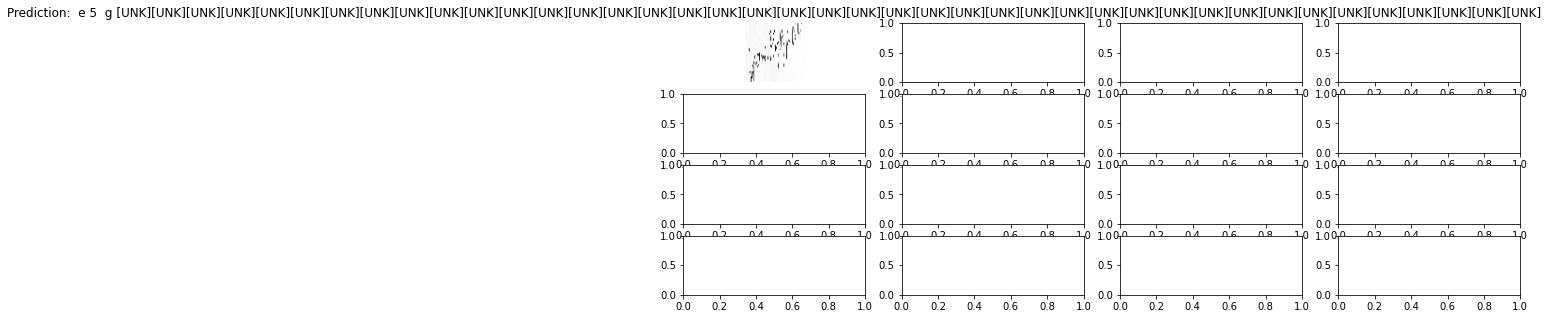

In [300]:
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :49
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)
    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [ ]:
#CNN TRIX

In [ ]:
#CNN CARL